In [51]:
import nltk, re
import pandas as pd
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Creem un diccionari de documents on posarem el text de cada document

In [52]:
tr_pos_docs = {}
te_pos_docs = {}
for i,val in enumerate(mr.fileids('pos')):
    if i < len(mr.fileids('pos'))*0.9:
        tr_pos_docs[val] = mr.raw(val)
    else:
        te_pos_docs[val] = mr.raw(val)

tr_neg_docs = {}
te_neg_docs = {}
for i,val in enumerate(mr.fileids('neg')):
    if i < len(mr.fileids('neg'))*0.9:
        tr_neg_docs[val] = mr.raw(val)
    else:
        te_neg_docs[val] = mr.raw(val)

tr_neg_docs.update(tr_pos_docs)
te_neg_docs.update(te_pos_docs)
train = tr_neg_docs 
test = te_neg_docs



#1800 documents per train i 200 per test



#### Fem la primer neteja de carácters que no aporten informació així com preprocés bàsic

El segundo re elimina todos los signos de puntuación !! (así se quita los accentos raros que salian)

In [53]:
for i in train.keys():
    train[i] = train[i].replace("&nbsp ;","")
    train[i] = train[i].replace("\n", "")
    train[i] = train[i].lower()
    train[i] = re.sub(r"\d","",train[i])
    train[i] = re.sub(r'[^\w\s]', '', train[i])


In [54]:
tokenitzador = lambda x: nltk.word_tokenize(x)

In [55]:
X = CountVectorizer(strip_accents='ascii',lowercase=True,tokenizer=tokenitzador,stop_words=stop_words, min_df=0.2)
X.fit_transform(train.values())


C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


<1800x159 sparse matrix of type '<class 'numpy.int64'>'
	with 93766 stored elements in Compressed Sparse Row format>

In [56]:
features = X.get_feature_names()
df = pd.DataFrame(columns=["sentimiento"] + features)

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [57]:
for i, val in enumerate(train.keys()):
    valor = X.transform([train[val]]).toarray()
    df.loc[len(df)] = [val[0:3]] + list(valor[0])


In [50]:
df_train = df

In [58]:
features = X.get_feature_names()
df_test = pd.DataFrame(columns=["sentimiento"] + features)

In [59]:
for i, val in enumerate(test.keys()):
    valor = X.transform([test[val]]).toarray()
    df_test.loc[len(df_test)] = [val[0:3]] + list(valor[0])

# Creem el model inicial, farem servir random forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df_train.sample(frac=1, replace= True, random_state=22)
df_test.sample(frac=1, replace= True, random_state=22)

y_train = df_train["sentimiento"]
x_train = df_train.drop(columns=["sentimiento"])

y_test = df_test["sentimiento"]
x_test = df_test.drop(columns=["sentimiento"])
# Crear un modelo de Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=500, random_state=22)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(x_train, y_train)

# Predecir la clase de los datos de prueba
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)


print(f"Accuracy en train: {accuracy_score(y_train, y_pred_train)} \n Accuracy en test: {accuracy_score(y_test, y_pred_test)} ")



Accuracy en train: 1.0 
 Accuracy en test: 0.77 


In [66]:
importances = rf.feature_importances_

# Crear un DataFrame con las importancias de las características
df_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Ordenar el DataFrame por importancia descendente
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

      feature  importance
15        bad    0.037890
72       life    0.017656
43       film    0.016483
6        also    0.014815
57      great    0.014485
..        ...         ...
120      seem    0.003605
68       kind    0.003475
63    instead    0.003387
107  probably    0.003234
130      sure    0.003109

[159 rows x 2 columns]


## Análisis del modelo

Como se puede observar, el modelo toma mayor consideración a la hora de clasificar un texto cuando aparece la palabra **bad**, tambien cabe destacar que existen palabras que se fija el modelo que no tienen sentido en cuanto a significado, como preposiciones o adverbios. Es por ello, que se modificará el train para que solo se fije en nombres, adjetivos y verbos. Además, así podremos reducir la dimensionalidad.

In [67]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [73]:
new_train = {}

for i in train.keys():
    tags = nltk.pos_tag(nltk.word_tokenize(train[i]))
    frase = ""
    for val in tags:
        if val[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ','NN', 'NNS', 'JJ', 'JJR', 'JJS']:
            frase += val[0] + " "
    new_train[i] = frase

Una vegada que hem obtingut verbs, noms y adjectius, n'hem a entrenar el nostre count vectorizer en el train.

In [74]:
X = CountVectorizer(strip_accents='ascii',lowercase=True,tokenizer=tokenitzador,stop_words=stop_words, min_df=0.2)
X.fit_transform(new_train.values())

features = X.get_feature_names()
df_train = pd.DataFrame(columns=["sentimiento"] + features)

for i, val in enumerate(new_train.keys()):
    valor = X.transform([new_train[val]]).toarray()
    df_train.loc[len(df_train)] = [val[0:3]] + list(valor[0])

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)
C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [75]:
features = X.get_feature_names()
df_test = pd.DataFrame(columns=["sentimiento"] + features)

for i, val in enumerate(test.keys()):
    valor = X.transform([test[val]]).toarray()
    df_test.loc[len(df_test)] = [val[0:3]] + list(valor[0])

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Creem el model ambs els mateixos hiperparámetres

In [79]:

df_train.sample(frac=1, replace= True, random_state=22)
df_test.sample(frac=1, replace= True, random_state=22)

y_train = df_train["sentimiento"]
x_train = df_train.drop(columns=["sentimiento"])

y_test = df_test["sentimiento"]
x_test = df_test.drop(columns=["sentimiento"])
# Crear un modelo de Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=500, random_state=22)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(x_train, y_train)

# Predecir la clase de los datos de prueba
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)


print(f"Accuracy en train: {accuracy_score(y_train, y_pred_train)} \nAccuracy en test: {accuracy_score(y_test, y_pred_test)} ")



Accuracy en train: 1.0 
Accuracy en test: 0.72 


              precision    recall  f1-score   support

         neg       0.74      0.67      0.71       100
         pos       0.70      0.77      0.73       100

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



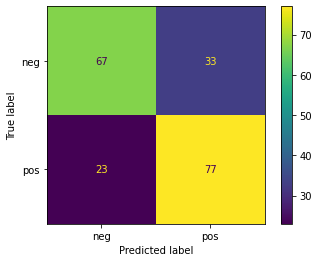

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_pred= y_pred_test, y_true= y_test))
print("===========================================================")
a = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=["neg", "pos"])
a.plot()

Mirem la importància de les labels en el nou model

In [78]:
importances = rf.feature_importances_

# Crear un DataFrame con las importancias de las características
df_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Ordenar el DataFrame por importancia descendente
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

    feature  importance
5       bad    0.044809
26     film    0.022982
52     life    0.022496
64    movie    0.019646
40    great    0.017873
..      ...         ...
7   becomes    0.005388
81    right    0.005291
41     help    0.005225
35    given    0.005033
48     kind    0.004845

[116 rows x 2 columns]


Com es pot observar, Hem reduit, en unes 60 paraules la quantitat de paraules a tenir en compte a l'hora de classificar els diferents textos. A més a més, hem aconseguit la mateixa accuracy que en l'anterior model tenint menys labels, per tant, s'ha reduit la dimensionalitat adequadament.

Com es pot observar, al reduir les variables, augmenten les importàncies de les labels en el model, on la més important segueix sent **bad**.

Si s'observa el report de classificcació, es pot observar com per la classe negatiu tenim més precissió que la positiva, això pot ser degut a la paraula "bad", que ajuda a la precisió de la negativa però pot ser existeixen exemples que no la tenen i per tant, no arribar a reconèixer bé la classe (el nivell de recall és més inferior).